## Logistic Regression

In [69]:
import numpy as np
import scipy.sparse as sp
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

### Logistic Regression

From http://www.edwardtufte.com/tufte/ebooks, in "Visual and Statistical Thinking: 
Displays of Evidence for Making Decisions":

>On January 28, 1986, the space shuttle Challenger exploded and seven astronauts died because two rubber O-rings leaked. These rings had lost their resiliency because the shuttle was launched on a very cold day. Ambient temperatures were in the low 30s and the O-rings themselves were much colder, less than 20F.

>One day before the flight, the predicted temperature for the launch was 26F to 29F. Concerned that the rings would not seal at such a cold temperature, the engineers who designed the rocket opposed launching Challenger the next day.

> But they did not make their case persuasively, and were over-ruled by NASA.

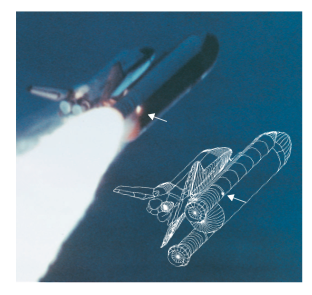

In [71]:
from IPython.display import Image as Im
from IPython.display import display
Im('./data/shuttle.png')

#The image below shows the leak, where the O-ring failed.



We have here data on previous failures of the O-rings at various temperatures.
Lets read the data from the file 'challenger.txt'. There is only 28 data points, where the first column represents the temperate and the second column is a Boolean that indicates if launch was a success (1) or a failure (0). 

In [73]:

data=np.array([[float(j) for j in e.strip().split()] for e in open("./data/challenger.txt")])
data


array([[ 66.,   0.],
       [ 70.,   1.],
       [ 69.,   0.],
       [ 68.,   0.],
       [ 67.,   0.],
       [ 72.,   0.],
       [ 73.,   0.],
       [ 70.,   0.],
       [ 57.,   1.],
       [ 63.,   1.],
       [ 70.,   1.],
       [ 78.,   0.],
       [ 67.,   0.],
       [ 53.,   1.],
       [ 67.,   0.],
       [ 75.,   0.],
       [ 70.,   0.],
       [ 81.,   0.],
       [ 76.,   0.],
       [ 79.,   0.],
       [ 75.,   1.],
       [ 76.,   0.],
       [ 58.,   1.]])

Lets plot this data

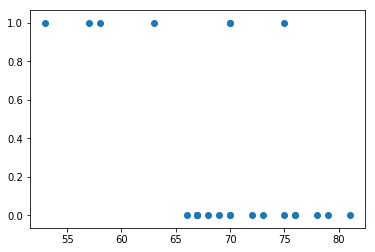

In [74]:
temps, pfail = data[:,0], data[:,1]   # separate the columns into vectors, 'temps' & 'pfail'
plt.scatter(temps, pfail) # Polt datapoints on a scatter matrix 

A value of 1 on the y-axis represents failure, and 0 represents success. This graph has a classic sigmoid shape, so one might expect logistic regression to work. Furthermore, we do want to find the probability of failure and make predictions from there.

Logistic regression is carried out in the same way as linear. However, there is the "pesky" matter of setting the regularization co-efficient `C`. 

The default `C` in sklearn is 1. The meaning of `C` is: the larger the `C`, the lesser the regularization. The smaller the `C` the higher the regularization.

What does regularization do? Larger regularizations penalize the values of regression coefficients. Smaller ones let the co-efficients range widely. Thus, larger `C` let the regression coefficients range widely. Scikit-learn bakes in two penalties: a l2 penalty which penalizes the sum of the squares of the coefficients, and a l1 penalty which penalizes the sum of the absolute values.

The reason for doing this is that is there are many co-variates we use for our prediction: we want to make sure we can get away with the simplest model that describes our data, even if that might increase the bias side of the bias-variance tradeoff a bit.

Remember here, though, that we have just two co-efficents: an intercept, and the outside temperature. So we do not expect to need regularization much. Indeed lets set `C=1000`.

In [75]:
from sklearn.linear_model import LogisticRegression

reg=1000. # define variable 

model = LogisticRegression(C=reg)
model.fit(temps.reshape(-1,1), pfail)  # Fit model on given datapoints 

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Lets make predictions, get the associated probabilities, and plot them. We create a new grid of temperatures to evaluate our predictions. Note that we do not do a test/train split: we have only 23 data points, but need to shut down the launch if there is any doubt. 

In [76]:
tempsnew=np.linspace(20., 90., 15)  # generate x axis
probs = model.predict_proba(tempsnew.reshape(-1,1))[:, 1]
predicts = model.predict(tempsnew.reshape(-1,1))

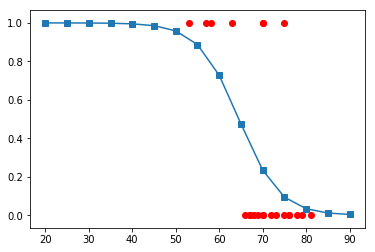

In [77]:
plt.scatter(temps, pfail, color="red") # plot actual data points

plt.plot(tempsnew, probs, marker='s') # plot the probability of classifiation
#plt.scatter(tempsnew, predicts, marker='s', color="green") # 

We use pandas `crosstab` to write a table of prediction vs failure on the "training" set. As one might expect, the mislabellings come at the higher temperatures.

In [78]:
pd.crosstab(pfail, model.predict(temps.reshape(-1,1)), \
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,16,0
1.0,3,4


> YOUR TURN NOW

Carry out a Logistic Regression with scikit-learn's default value for `C`. Make a plot similar to the scatterplot above, and carry out the cross-tabulation. What happens?

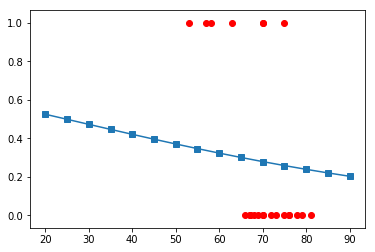

In [61]:

model = LogisticRegression() # default C = 1
model.fit(temps.reshape(-1,1), pfail)
probsw = model.predict_proba(tempsnew.reshape(-1,1))[:, 1]
predictsw = model.predict(tempsnew.reshape(-1,1))
plt.scatter(temps, pfail, color="red")

plt.plot(tempsnew, probsw, marker='s')
#plt.scatter(tempsnew, predictsw, marker='s', color="green")

In [79]:
#your code here
pd.crosstab(pfail, model.predict(temps.reshape(-1,1)), rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,16,0
1.0,3,4


#### Logistic Regression with cross-validation

We now actually go ahead and to the train/test split. Not once but multiple times, on a grid search, for different values of `C`. For each `C`, we:

1. create `n_folds` folds. Since the data size is 23 here, and we have 5 folds, we roughly split the data into 5 folds of 4-5 values each, randomly. 
2. We then train on 4 of these folds, test on the 5th
3. We average the results of all such combinations
4. We move on to the next value of `C`, and find the optimal value that minimizes mean square error.
5. We finally use that value to make the final fit.

Notice the structure of the `GridSearchCV` estimator in `cv_optimize`.

In [33]:
from sklearn.linear_model import LogisticRegression
def fit_logistic(X_train, y_train, reg=0.0001, penalty="l2"):
    clf = LogisticRegression(C=reg, penalty=penalty)
    clf.fit(X_train, y_train)
    return clf

from sklearn.grid_search import GridSearchCV

def cv_optimize(X_train, y_train, paramslist, penalty="l2", n_folds=10):
    clf = LogisticRegression(penalty=penalty)
    parameters = {"C": paramslist}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X_train, y_train)
    return gs.best_params_, gs.best_score_

def cv_and_fit(X_train, y_train, paramslist, penalty="l2", n_folds=5):
    bp, bs = cv_optimize(X_train, y_train, paramslist, penalty=penalty, n_folds=n_folds)
    print "BP,BS", bp, bs
    clf = fit_logistic(X_train, y_train, penalty=penalty, reg=bp['C'])
    return clf

In [34]:
clf=cv_and_fit(temps.reshape(-1,1), pfail, np.logspace(-4, 3, num=100))


BP,BS {'C': 27.825594022071257} 0.826086956522


In [35]:
pd.crosstab(pfail, clf.predict(temps.reshape(-1,1)), rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,16,0
1.0,4,3


We plot our results, this time also marking in red the predictions on the "training" set.

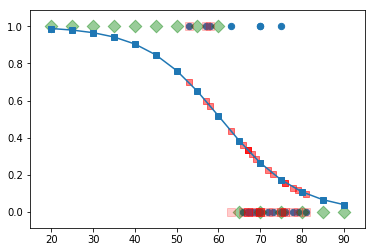

In [36]:
plt.scatter(temps, pfail, s=40)

probs=clf.predict_proba(tempsnew.reshape(-1,1))[:,1]
predicts=clf.predict(tempsnew.reshape(-1,1))
plt.plot(tempsnew, probs, marker='s')
plt.scatter(tempsnew, predicts, marker='D', color="green", s=80, alpha=0.4)
train_probs=clf.predict_proba(temps.reshape(-1,1))[:,1]
plt.scatter(temps, train_probs, marker='s', c='r', alpha=0.5, s=40)
train_predicts=clf.predict(temps.reshape(-1,1))
plt.scatter(temps, train_predicts, marker='s', c='r', alpha=0.2, s=80)

The failures in prediction are, exactly where you might have expected them to be, as before.

In [40]:
pd.crosstab(pfail, clf.predict(temps.reshape(-1,1)), rownames=["Actual"], colnames=["Predicted"])
#zip(temps,pfail, clf.predict(temps.reshape(-1,1)))

Predicted,0.0,1.0
Actual,,
0.0,16,0
1.0,4,3


We note that the true story was even worse than our data made it out to be! We did not take the severity of the incidents into account. How could we have incorporated this severity into our analysis? (these images are taken from Tufte's booklet).

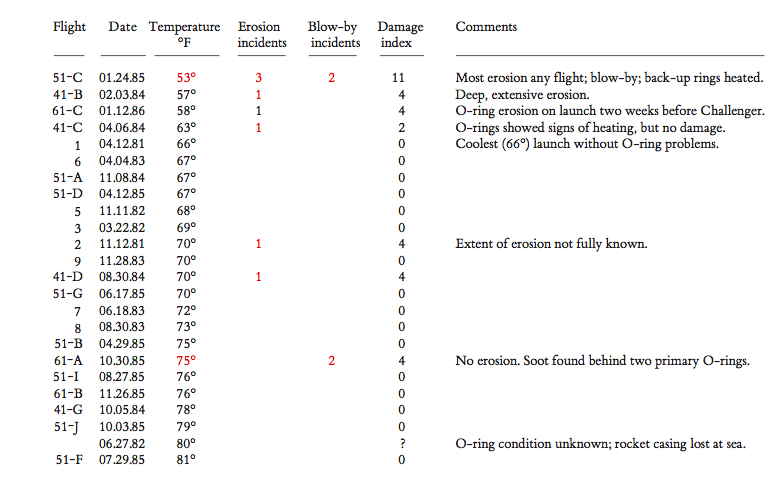

In [33]:
Im('./data/chall-table.png')